In [13]:
using LinearAlgebra
using Plots, Plots.PlotMeasures
using Colors
using LaTeXStrings
using MAT
using FFTW

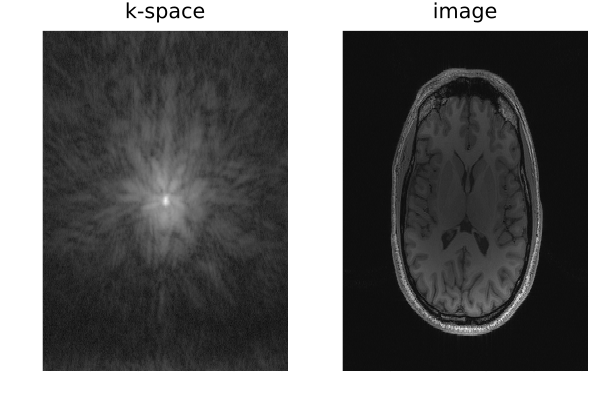

In [14]:
# load in the 2D data
kdata = 1e8 * matread("./2D_T1_human_data.mat")["kData"];
idata = fftshift(ifft(ifftshift(kdata,1:2),1:2),1:2);

# take rsos for visualization
kdata_rsos = sqrt.(sum(abs2.(kdata); dims=3))[:,:,1];
idata_rsos = sqrt.(sum(abs2.(idata); dims=3))[:,:,1];
fake_noise = maximum(idata_rsos) * randn(size(idata_rsos));

p1 = heatmap(log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, title="k-space")
p2 = heatmap(idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="image")

plot(p1,p2)

In [15]:
# function to define trapezoid given area, max height, and max first derivative
function trap_A(A, hmax, smax)

    # get initial height
    h = min(hmax, sqrt(A / smax))

    # get number of discrete ramp points
    nramp = ceil(Int, h / smax)

    # get number of discrete plateau points
    Aplat = A - h * nramp
    nplat = ceil(Int, max(0, Aplat / h))

    # adjust height
    h = A / (nramp + nplat)

    # form trapezoid
    trap = h / nramp * collect(1:nramp) # ramp up
    append!(trap, h * ones(nplat)) # plateau
    append!(trap, h / nramp * collect(nramp-1:-1:0)) # ramp down

    return (trap,h,nramp,nplat)
end

function trap_hl(h, l, smax)

    # get number of discrete ramp points
    nramp = ceil(Int, h / smax)

    # get number of discrete plateau points
    nplat = ceil(Int, l)

    # form trapezoid
    trap = h / nramp * collect(1:nramp) # ramp up
    append!(trap, h * ones(nplat)) # plateau
    append!(trap, h / nramp * collect(nramp-1:-1:0)) # ramp down

    return (trap,h,nramp,nplat)
end

function epi(nx,ny;ry=1,sr=0.05)

    # create frequency encode gradient
    (trap_fe,a_fe,nramp_fe,nplat_fe) = trap_hl(1,nx,sr)
    gx_fe = trap_fe
    gy_fe = zeros(length(trap_fe))
    acq_fe = vcat(zeros(length(nramp_fe)), ones(length(nplat_fe)), zeros(nramp_fe))

    # create phase encode gradient
    (trap_pe,a_pe,nramp_pe,nplat_pe) = trap_A(1/ry,1,sr)
    gx_pe = zeros(length(trap_pe))
    gy_pe = trap_pe
    acq_pe = zeros(length(trap_pe))

    # create prephaser gradient
    A_ppx = a_fe * (nplat_fe + nramp_fe) / 2
    A_ppy = (ny/ry)/2
    (trap_ppx,_,_,_) = trap_A(A_ppx,1,sr)
    (trap_ppy,_,_,_) = trap_A(A_ppy,1,sr)
    if length(trap_ppx) > length(trap_ppy)
        gx_pp = -trap_ppx
        gy_pp = vcat(-trap_ppy, zeros(length(trap_ppx) - length(trap_ppy)))
    else
        gx_pp = vcat(-trap_ppx, zeros(length(trap_ppy) - length(trap_ppx)))
        gy_pp = -trap_ppy
    end
    acq_pp = zeros(length(gx_pp))

    # build EPI trajectory
    gx_epi = gx_pp
    gy_epi = gy_pp
    acq_epi = acq_pp
    for i in 1:ny
        # frequency encode
        append!(gx_epi, (-1)^(i-1)*gx_fe)
        append!(gy_epi, gy_fe)
        append!(acq_epi, acq_fe)

        if i < ny
            # phase encode
            append!(gx_epi, gx_pe)
            append!(gy_epi, gy_pe)
            append!(acq_epi, acq_pe)
        end
    end

    return gx_epi, gy_epi, acq_epi
end

epi (generic function with 1 method)

In [120]:
function tetra(SNR,sr,tr,pl;theta=0,fs=14)

    # offset angle
    phi = theta / 180 * pi - atan(sin(4 / 3 * pi + pi / 2))

    if theta == 0 # triangles only
        wf = [
            cos(2 / 3 * pi + pi / 2) cos(phi)*sin(2 / 3 * pi + pi / 2);
            0 cos(phi);
            cos(4 / 3 * pi + pi / 2) cos(phi)*sin(4 / 3 * pi + pi / 2);
            cos(2 / 3 * pi + pi / 2) cos(phi)*sin(2 / 3 * pi + pi / 2)
        ]

        th = [SNR; sr; tr; SNR] .* wf
        p = plot(wf[:, 1], wf[:, 2],
            color=:black,
            linewidth=2,
            xlim=(-1, 2), ylim=(-1, 1.5)
        )
        plot!(p, th[:, 1], th[:, 2], color=red2, fill=(0, :auto), alpha=0.6, grid=false, axis=false, legend=false)

        # make text
        annotate!(p, (0, 1.1 * cos(phi), text("Spatial\nResolution", :center, :bottom, fs)))
        annotate!(p, (1.1 * cos(2 / 3 * pi + pi / 2), cos(phi) * sin(2 / 3 * pi + pi / 2), text("SNR", :right, fs)))
        annotate!(p, (1.1 * cos(4 / 3 * pi + pi / 2), cos(phi) * sin(4 / 3 * pi + pi / 2), text("Temporal\nResolution", :left, fs)))

    else

        # base of the tetrahedron
        wf1 = [
            cos(2 / 3 * pi + pi / 2) cos(phi)*sin(2 / 3 * pi + pi / 2);
            cos(4 / 3 * pi + pi / 2) cos(phi)*sin(4 / 3 * pi + pi / 2);
            0 -sin(phi);
            cos(2 / 3 * pi + pi / 2) cos(phi)*sin(2 / 3 * pi + pi / 2)
        ]
        th1 = [SNR; tr; pl; SNR] .* wf1

        wf2 = [
            cos(2 / 3 * pi + pi / 2) cos(phi)*sin(2 / 3 * pi + pi / 2);
            0 -sin(phi);
            0 cos(phi);
            cos(2 / 3 * pi + pi / 2) cos(phi)*sin(2 / 3 * pi + pi / 2)
        ]
        th2 = [SNR; pl; sr; SNR] .* wf2

        wf3 = [
            cos(4 / 3 * pi + pi / 2) cos(phi)*sin(4 / 3 * pi + pi / 2);
            0 -sin(phi);
            0 cos(phi);
            cos(4 / 3 * pi + pi / 2) cos(phi)*sin(4 / 3 * pi + pi / 2)
        ]
        th3 = [tr; pl; sr; tr] .* wf3

        red_shadow = (1 - theta / 90) * red2
        p = plot(wf1[:, 1], wf1[:, 2], color=:black, line=:dash, linewidth=2, grid=false, axis=false, legend=false,
            xlim=(-1, 2), ylim=(-1, 1.5))
        plot!(p,th1[:, 1], th1[:, 2], color=red2, fill=(0, :auto), linewidth=0, alpha=0.6)
        plot!(p,th2[:, 1], th2[:, 2], color=red2, fill=(0, :auto), linewidth=0, alpha=0.6)
        plot!(p,th3[:, 1], th3[:, 2], color=red_shadow, fill=(0, :auto), linewidth=0, alpha=0.6)
        plot!(p,wf2[:, 1], wf2[:, 2], color=:black, linewidth=2)
        plot!(p,wf3[:, 1], wf3[:, 2], color=:black, linewidth=2)

        # make text
        annotate!(p, (0, 1.1*cos(phi), text("Spatial\nResolution", :center, :bottom, fs)))
        annotate!(p, (1.1*cos(2 / 3 * pi + pi / 2), cos(phi) * sin(2 / 3 * pi + pi / 2), text("SNR", :right, fs)))
        annotate!(p, (1.1*cos(4 / 3 * pi + pi / 2), cos(phi) * sin(4 / 3 * pi + pi / 2), text("Temporal\nResolution", :left, fs)))
        annotate!(p, (0, -1.1*sin(phi), text("Respect for\nPhysical Limits", :center, :top, fs)))

    end

    return p
end

tetra (generic function with 2 methods)

In [27]:
# Color definitions (replace hex2rgb with RGB values or use Colors.jl if needed)
red2 = RGB(0x9A/255.0, 0x33/255.0, 0x24/255.0)
orange = RGB(0xD8/255.0, 0x60/255.0, 0x18/255.0)
green = RGB(0x75/255.0, 0x98/255.0, 0x8d/255.0)
teal = RGB(0x00/255.0, 0xB2/255.0, 0xA9/255.0)
blue2 = RGB(0x2F/255.0, 0x65/255.0, 0xA7/255.0)
dblue = RGB(0x00/255.0, 0x27/255.0, 0x4C/255.0)
amethyst = RGB(0x70/255.0, 0x20/255.0, 0x82/255.0)
maize = RGB(0xFF/255.0, 0xCB/255.0, 0x05/255.0)

In [17]:
nx = 64
ny = 16
npts = 10 # number of frames in transition animations

10

┌ Info: Saved animation to /Users/djfrey/code/lps_figures/compiled_figures/epi.gif
└ @ Plots /Users/djfrey/.julia/packages/Plots/xKhUG/src/animation.jl:156


Plots.AnimatedGif("/Users/djfrey/code/lps_figures/compiled_figures/epi.gif")
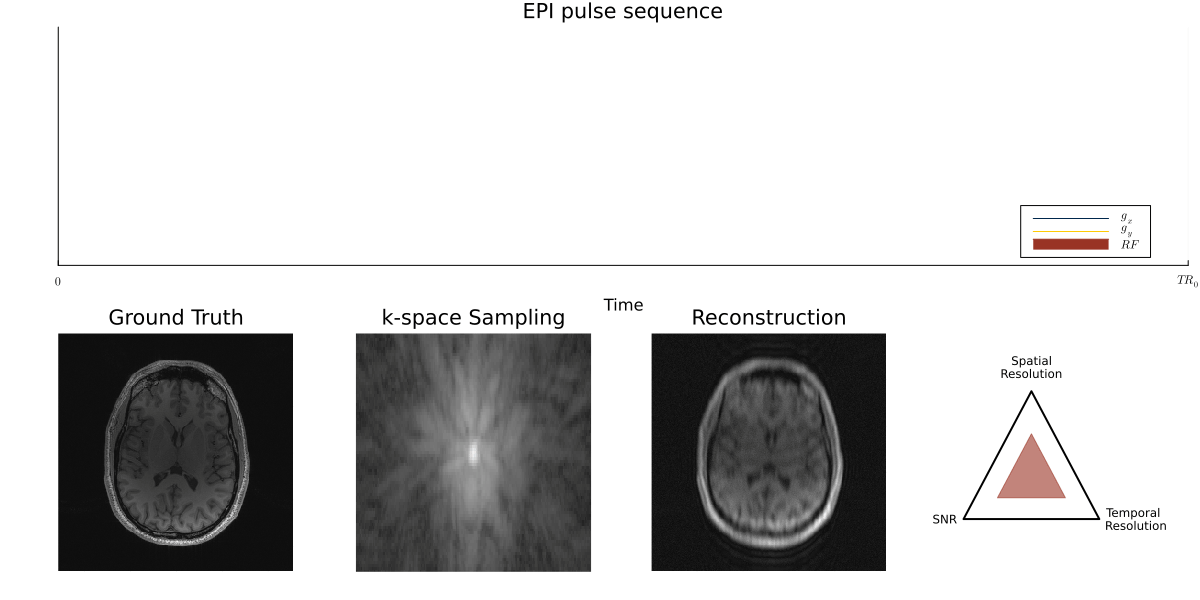

In [125]:
SNR = 1;


# create baseline EPI sequence
(gx,gy,acq) = epi(nx,ny;ry=1,sr=0.01)

# append excitation
mysinc = x -> x == 0 ? 1 : sinpi(x)/(pi*x)
rf_len = 128;
rf = vcat(mysinc.(range(-4,4,rf_len)), zeros(length(gx)))
gx = vcat(zeros(rf_len), gx)
gy = vcat(zeros(rf_len), gy)
acq = vcat(zeros(rf_len), acq)

# get the time
t = collect(0:length(gx)-1)
tr_0 = maximum(t)

anim = @animate for i = vcat(1:100:length(t), length(t))
    # plot the sequence
    pseq = plot(t[1:i], gx[1:i],
        xlim=(0,maximum(t)), ylim=(-1.1, 1.1),
        color=dblue,
        label=L"g_x",
        xticks=([0,tr_0],[L"0", L"TR_0"]),
        yticks=false,
        legend=:bottomright)
    plot!(pseq,
        t[1:i], 10*gy[1:i],
        color=maize,
        label=L"g_y",)
    plot!(pseq,
        t[1:i], rf[1:i],
        color=red2,
        label=L"RF",
        yticks=false,
        fill=(0, :auto),
        xlabel="Time", ylabel="",
        title="EPI pulse sequence")

    # show the ground truth image
    X = -Int(floor(size(idata_rsos,1)/2)):Int(ceil(size(idata_rsos,1)/2))-1
    Y = -Int(floor(size(idata_rsos,2)/2)):Int(ceil(size(idata_rsos,2)/2))-1
    pgt = heatmap(X,Y,idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="Ground Truth")

    # plot the kspace trajectory
    kx = cumsum(gx)
    ky = 2*cumsum(gy)
    X = -Int(floor(size(kdata_rsos,1)/2)):Int(ceil(size(kdata_rsos,1)/2))-1
    Y = -Int(floor(size(kdata_rsos,2)/2)):Int(ceil(size(kdata_rsos,2)/2))-1
    pks = heatmap(X,Y,log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, xlim=(1.1*minimum(kx), 1.1*maximum(kx)), ylim=(-40,40), title="k-space Sampling")
    plot!(pks, kx[1:i], ky[1:i], color=maize, linewidth=2,label=false)

    # simulate the reconstructed image
    X = floor(Int,size(idata_rsos,1)/2) .+ (-Int(nx):Int(nx-1))
    Y = floor(Int,size(idata_rsos,2)/2) .+ (-Int(ny):Int(ny-1))
    kdata_tmp = zeros(ComplexF64,size(idata_rsos))
    kdata_tmp[Y,X] = fftshift(fft(ifftshift(idata_rsos)))[Y,X]
    idata_tmp = fftshift(ifft(ifftshift(kdata_tmp))) .+ 0.01/SNR * fake_noise
    prc = heatmap(abs.(idata_tmp), color=:grays, colorbar=false, axis=false, yflip=true, title="Reconstruction")

    # show triangle of death
    ptd = tetra(0.5, 0.5, 0.5, 0.5; theta=0, fs=8)

    psamp = plot(pgt,pks,prc,ptd,layout=(1,4))
    pall = plot(pseq,psamp,layout=(2,1),size=(1200,600))
    
end

gif(anim, "compiled_figures/epi.gif", fps=30, loop=-1)

┌ Info: Saved animation to /Users/djfrey/code/lps_figures/compiled_figures/epi_res.gif
└ @ Plots /Users/djfrey/.julia/packages/Plots/xKhUG/src/animation.jl:156


Plots.AnimatedGif("/Users/djfrey/code/lps_figures/compiled_figures/epi_res.gif")
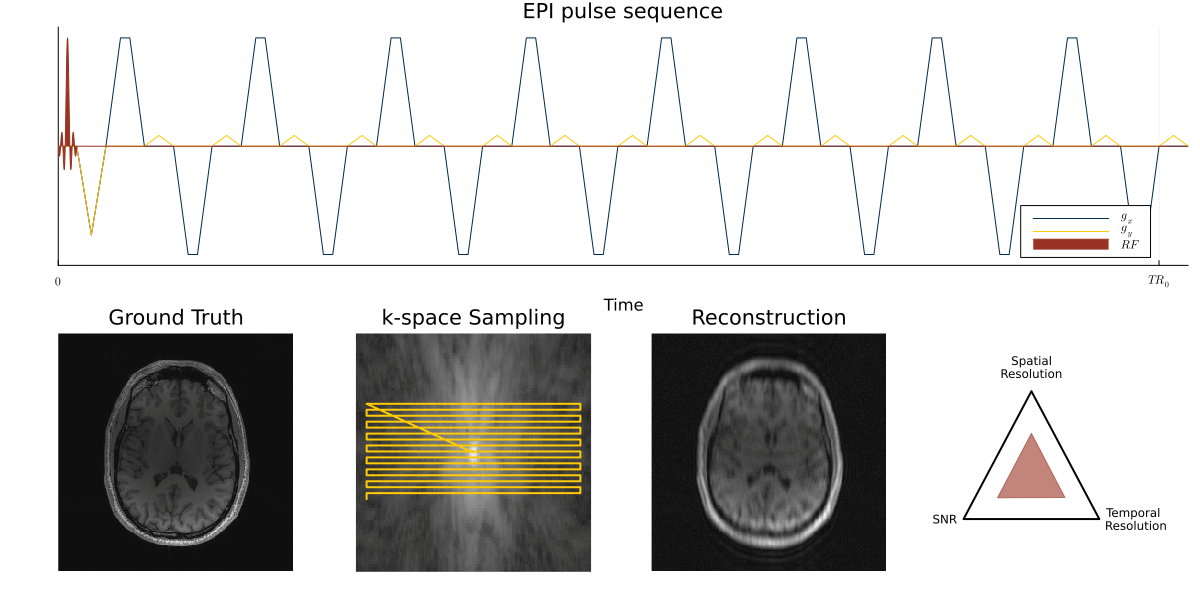

In [126]:
npts = 40

anim = @animate for i = 1:npts

    # increase the resolution
    (gx,gy,acq) = epi(nx,(1+i/npts)*ny;ry=1,sr=0.01)

    # append excitation
    mysinc = x -> x == 0 ? 1 : sinpi(x)/(pi*x)
    rf_len = 128;
    rf = vcat(mysinc.(range(-4,4,rf_len)), zeros(length(gx)))
    gx = vcat(zeros(rf_len), gx)
    gy = vcat(zeros(rf_len), gy)
    acq = vcat(zeros(rf_len), acq)

    # get the time
    t = collect(0:length(gx)-1)

    # plot the sequence
    pseq = plot(t, gx,
        xlim=(0,maximum(t)), ylim=(-1.1, 1.1),
        color=dblue,
        label=L"g_x",
        xticks=([0,tr_0],[L"0", L"TR_0"]),
        yticks=false,
        legend=:bottomright)
    plot!(pseq,
        t, 10*gy,
        color=maize,
        label=L"g_y",)
    plot!(pseq,
        t, rf,
        color=red2,
        label=L"RF",
        yticks=false,
        fill=(0, :auto),
        xlabel="Time", ylabel="",
        title="EPI pulse sequence")

    # show the ground truth image
    X = -Int(floor(size(idata_rsos,1)/2)):Int(ceil(size(idata_rsos,1)/2))-1
    Y = -Int(floor(size(idata_rsos,2)/2)):Int(ceil(size(idata_rsos,2)/2))-1
    pgt = heatmap(X,Y,idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="Ground Truth")

    # plot the kspace trajectory
    kx = cumsum(gx)
    ky = 2*cumsum(gy)
    X = -Int(floor(size(kdata_rsos,1)/2)):Int(ceil(size(kdata_rsos,1)/2))-1
    Y = -Int(floor(size(kdata_rsos,2)/2)):Int(ceil(size(kdata_rsos,2)/2))-1
    pks = heatmap(X,Y,log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, xlim=(1.1*minimum(kx), 1.1*maximum(kx)), ylim=(-40,40), title="k-space Sampling")
    plot!(pks, kx, ky, color=maize, linewidth=2,label=false)

    # simulate the reconstructed image
    X = floor(Int,size(idata_rsos,1)/2) .+ (-Int(nx):Int(nx-1))
    Y = floor(Int,size(idata_rsos,2)/2) .+ (-ceil(Int,(1+i/npts)*ny):ceil(Int,(1+i/npts)*ny-1))
    kdata_tmp = zeros(ComplexF64,size(idata_rsos))
    kdata_tmp[Y,X] = fftshift(fft(ifftshift(idata_rsos)))[Y,X]
    idata_tmp = fftshift(ifft(ifftshift(kdata_tmp))) .+ 0.01/SNR * fake_noise
    prc = heatmap(abs.(idata_tmp), color=:grays, colorbar=false, axis=false, yflip=true, title="Reconstruction")

    # show triangle of death
    ptd = tetra(0.5, 0.5 + 0.25 * i / npts, 0.5 - 0.25 * i / npts, 0.5; theta=0, fs=8)

    psamp = plot(pgt, pks, prc, ptd, layout=(1, 4))
    pall = plot(pseq, psamp, layout=(2, 1), size=(1200, 600))
    
end

gif(anim, "compiled_figures/epi_res.gif", fps=30, loop=-1)

┌ Info: Saved animation to /Users/djfrey/code/lps_figures/compiled_figures/epi_snr.gif
└ @ Plots /Users/djfrey/.julia/packages/Plots/xKhUG/src/animation.jl:156


Plots.AnimatedGif("/Users/djfrey/code/lps_figures/compiled_figures/epi_snr.gif")
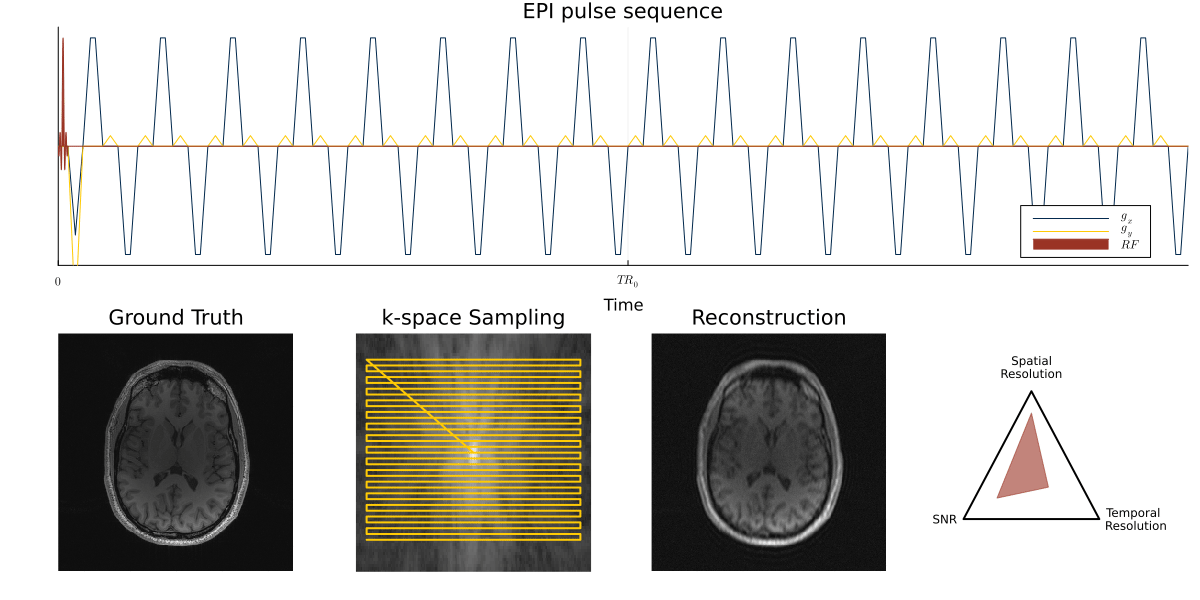

In [127]:
# reverse the resolution and boost the SNR

anim = @animate for i = 1:npts

    # increase the resolution
    (gx,gy,acq) = epi(nx,2*ny;ry=1+i/npts,sr=0.01)

    # append excitation
    mysinc = x -> x == 0 ? 1 : sinpi(x)/(pi*x)
    rf_len = 128;
    rf = vcat(mysinc.(range(-4,4,rf_len)), zeros(length(gx)))
    gx = vcat(zeros(rf_len), gx)
    gy = vcat(zeros(rf_len), gy)
    acq = vcat(zeros(rf_len), acq)

    # get the time
    t = collect(0:length(gx)-1)

    # plot the sequence
    pseq = plot(t, gx,
        xlim=(0,maximum(t)), ylim=(-1.1, 1.1),
        color=dblue,
        label=L"g_x",
        xticks=([0,tr_0],[L"0", L"TR_0"]),
        yticks=false,
        legend=:bottomright)
    plot!(pseq,
        t, 10*gy,
        color=maize,
        label=L"g_y",)
    plot!(pseq,
        t, rf,
        color=red2,
        label=L"RF",
        yticks=false,
        fill=(0, :auto),
        xlabel="Time", ylabel="",
        title="EPI pulse sequence")

    # show the ground truth image
    X = -Int(floor(size(idata_rsos,1)/2)):Int(ceil(size(idata_rsos,1)/2))-1
    Y = -Int(floor(size(idata_rsos,2)/2)):Int(ceil(size(idata_rsos,2)/2))-1
    pgt = heatmap(X,Y,idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="Ground Truth")

    # plot the kspace trajectory
    kx = cumsum(gx)
    ky = 2*cumsum(gy)
    X = -Int(floor(size(kdata_rsos,1)/2)):Int(ceil(size(kdata_rsos,1)/2))-1
    Y = -Int(floor(size(kdata_rsos,2)/2)):Int(ceil(size(kdata_rsos,2)/2))-1
    pks = heatmap(X,Y,log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, xlim=(1.1*minimum(kx), 1.1*maximum(kx)), ylim=(-40,40), title="k-space Sampling")
    plot!(pks, kx, ky, color=maize, linewidth=2,label=false)

    # simulate the reconstructed image
    X = floor(Int,size(idata_rsos,1)/2) .+ (-Int(nx):Int(nx-1))
    Y = floor(Int,size(idata_rsos,2)/2) .+ (-ceil(Int,(2 - i/npts)*ny):ceil(Int,(2 - i/npts)*ny-1))
    kdata_tmp = zeros(ComplexF64,size(idata_rsos))
    kdata_tmp[Y,X] = fftshift(fft(ifftshift(idata_rsos)))[Y,X]
    idata_tmp = fftshift(ifft(ifftshift(kdata_tmp))) .+ 0.01/(1 + i/npts) * fake_noise
    prc = heatmap(abs.(idata_tmp), color=:grays, colorbar=false, axis=false, yflip=true, title="Reconstruction")

    # show triangle of death
    ptd = tetra(0.5 + 0.25*i/npts, 0.75 - 0.25 * i / npts, 0.25, 0.5; theta=0, fs=8)

    psamp = plot(pgt, pks, prc, ptd, layout=(1, 4))
    pall = plot(pseq, psamp, layout=(2, 1), size=(1200, 600))
    
end

gif(anim, "compiled_figures/epi_snr.gif", fps=30, loop=-1)

┌ Info: Saved animation to /Users/djfrey/code/lps_figures/compiled_figures/tetra_of_death.gif
└ @ Plots /Users/djfrey/.julia/packages/Plots/xKhUG/src/animation.jl:156


Plots.AnimatedGif("/Users/djfrey/code/lps_figures/compiled_figures/tetra_of_death.gif")
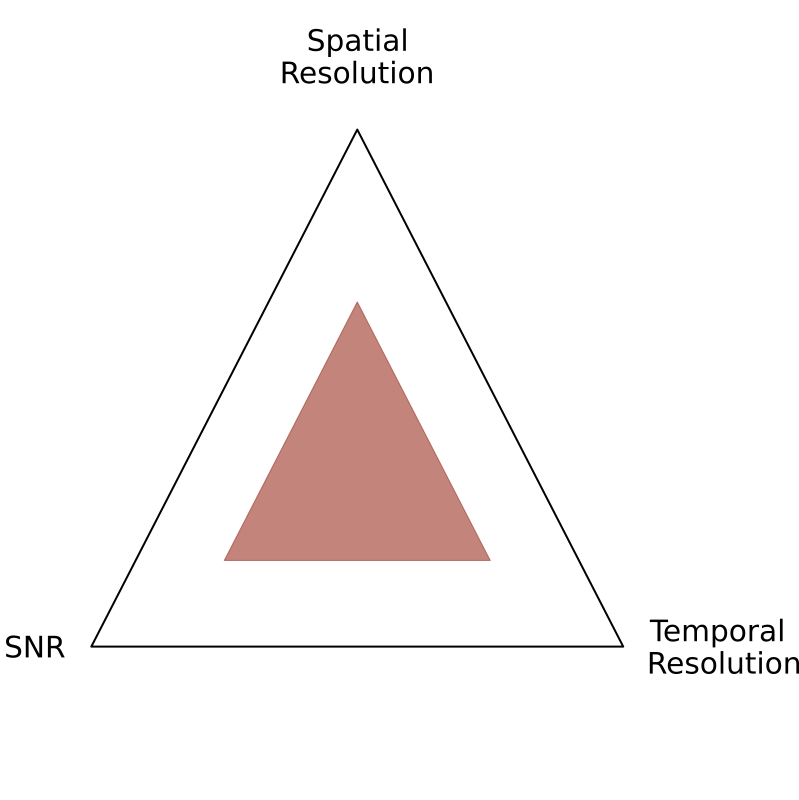

In [139]:
SNR = 0.5
sr = 0.5
tr = 0.5
pl = 0.5

npts = 50
anim = @animate for i in 0:npts
    p = tetra(SNR, sr, tr, pl; theta=sqrt(i/npts)*15, fs=20)
    plot(p, xlim=(-1, 1.4), ylim=(-0.75 - 0.25 * i / npts, 1.2 - 0.15 * i / npts), size=(800, 800))
end

gif(anim, "compiled_figures/tetra_of_death.gif", fps=30, loop=-1)

In [ ]:
- 180/pi * atan(sin(4 / 3 * pi + pi / 2))

-26.56505117707801

In [ ]:
@gif for theta in vcat(zeros(20), range(0, 10, 200))
    theta_rad = theta / 180 * pi  # convert to radians

    if theta == 0
        # flat triangle aligned with the tetrahedron base
        wf = [
            cos(2 / 3 * pi + pi / 2)*cos(theta_rad)*sin(2 / 3 * pi + pi / 2), sin(2 / 3 * pi + pi / 2);
            0 1;
            cos(4 / 3 * pi + pi / 2)*cos(theta_rad)*sin(4 / 3 * pi + pi / 2), sin(4 / 3 * pi + pi / 2);
            cos(2 / 3 * pi + pi / 2)*cos(theta_rad)*sin(2 / 3 * pi + pi / 2), sin(2 / 3 * pi + pi / 2)
        ]
        th = [SNR; sr; tr; SNR] .* wf

        plot(wf[:, 1], wf[:, 2],
            color=:black,
            linewidth=2,
            xlim=(minimum(wf[:, 1]), 1.1 * maximum(wf[:, 1])),
            ylim=(1.1 * minimum(wf[:, 2]), 1.1 * maximum(wf[:, 2]))
        )
        plot!(th[:, 1], th[:, 2], color=red2, fill=(0, :auto), alpha=0.6,
            grid=false, axis=false, legend=false)
    else
        # base of the tetrahedron
        wf1 = [
            cos(2 / 3 * pi + pi / 2),  cos(theta_rad) * sin(2 / 3 * pi + pi / 2),
            cos(4 / 3 * pi + pi / 2), cos(theta_rad) * sin(4 / 3 * pi + pi / 2),
            0,
            cos(2 / 3 * pi + pi / 2) * cos(theta_rad) * sin(2 / 3 * pi + pi / 2)
        ]
        th1 = [SNR; tr; pl; SNR] .* wf1

        wf2 = [
            cos(2 / 3 * pi + pi / 2) * cos(theta_rad) * sin(2 / 3 * pi + pi / 2);
            0;
            0;
            cos(2 / 3 * pi + pi / 2) * cos(theta_rad) * sin(2 / 3 * pi + pi / 2)
        ]
        th2 = [SNR; pl; sr; SNR] .* wf2

        wf3 = [
            cos(4 / 3 * pi + pi / 2) * cos(theta_rad) * sin(4 / 3 * pi + pi / 2);
            0;
            0;
            cos(4 / 3 * pi + pi / 2) * cos(theta_rad) * sin(4 / 3 * pi + pi / 2)
        ]
        th3 = [tr; pl; sr; tr] .* wf3

        red_shadow = (0.8 + 0.2 * cos(pi * 2 * theta / 180)) * red2
        plot(wf1[:, 1], wf1[:, 2], color=:black, linewidth=2, grid=false, axis=false, legend=false,
            xlim=(1.1 * minimum(wf1[:, 1]), 1.1 * maximum(wf1[:, 1])),
            ylim=(1.1 * minimum(wf1[:, 2]), 1.1 * maximum(wf2[:, 2]))
        )
        plot!(wf2[:, 1], wf2[:, 2], color=:black, linewidth=2)
        plot!(wf3[:, 1], wf3[:, 2], color=:black, linewidth=2)
        plot!(th1[:, 1], th1[:, 2], color=red2, fill=(0, :auto), linewidth=0, alpha=0.6)
        plot!(th2[:, 1], th2[:, 2], color=red2, fill=(0, :auto), linewidth=0, alpha=0.6)
        plot!(th3[:, 1], th3[:, 2], color=red_shadow, fill=(0, :auto), linewidth=0, alpha=0.6,
            title="theta = $theta")
    end
end


BoundsError: BoundsError: attempt to access 4-element Vector{Float64} at index [1:4, 2]

┌ Info: Saved animation to /var/folders/0g/9yswjs9x53vgk112mrdn05mm0000gn/T/jl_0x4dCl67Wf.gif
└ @ Plots /Users/djfrey/.julia/packages/Plots/xKhUG/src/animation.jl:156


Plots.AnimatedGif("/var/folders/0g/9yswjs9x53vgk112mrdn05mm0000gn/T/jl_0x4dCl67Wf.gif")
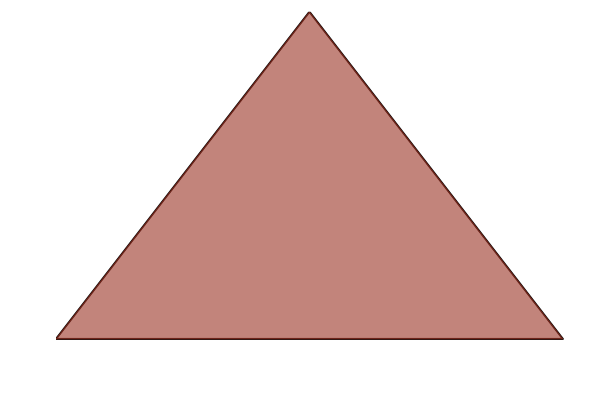

In [61]:
# Helper function to generate projected 2D coordinates for a face
function tetra_face(angle_idx, theta, scale)
    θ = theta / 180 * pi
    base_x = cos(angle_idx) * cos(θ) * sin(angle_idx)
    base_y = sin(angle_idx)
    return scale .* [base_x base_y]
end

# angles for the tetrahedron base (3 corners + repeat first)
angles = [2 / 3 * pi + pi / 2, 4 / 3 * pi + pi / 2, 0, 2 / 3 * pi + pi / 2]

@gif for theta in vcat(zeros(20), range(0, 10, 50))
    if theta == 0
        # flat triangle, no center wireframe
        wf = [tetra_face(a, theta, s) for (a, s) in zip(angles, [SNR, sr, tr, SNR])]
        wf = reduce(vcat, wf)
        plot(wf[:, 1], wf[:, 2],
            color=:black, linewidth=2,
            xlim=(minimum(wf[:, 1]), 1.1 * maximum(wf[:, 1])),
            ylim=(1.1 * minimum(wf[:, 2]), 1.1 * maximum(wf[:, 2])),
            grid=false, axis=false, legend=false
        )
        plot!(wf[:, 1], wf[:, 2], color=red2, fill=(0, :auto), alpha=0.6)
    else
        # tetrahedron faces
        scales_list = [[SNR, tr, pl, SNR],
            [SNR, pl, sr, SNR],
            [tr, pl, sr, tr]]
        wf_all = []
        th_all = []

        for (face_idx, scales) in enumerate(scales_list)
            wf_face = [tetra_face(a, theta, s) for (a, s) in zip(angles, scales)]
            wf_face = reduce(vcat, wf_face)
            push!(wf_all, wf_face)
            th_face = wf_face
            push!(th_all, th_face)
        end

        # plot each face
        for wf_face in wf_all
            plot!(wf_face[:, 1], wf_face[:, 2], color=:black, linewidth=2,
                grid=false, axis=false, legend=false)
        end

        # plot filled faces
        red_shadow = (0.8 + 0.2 * cos(pi * 2 * theta / 180)) * red2
        plot!(th_all[1][:, 1], th_all[1][:, 2], color=red2, fill=(0, :auto), linewidth=0, alpha=0.6)
        plot!(th_all[2][:, 1], th_all[2][:, 2], color=red2, fill=(0, :auto), linewidth=0, alpha=0.6)
        plot!(th_all[3][:, 1], th_all[3][:, 2], color=red_shadow, fill=(0, :auto), linewidth=0, alpha=0.6,
            title="theta = $theta")
    end
end
